# Tutorial: Detecção de Linhas de Pista para Carros Autônomos

Este tutorial demonstra como detectar e analisar linhas de pista usando OpenCV, incluindo:
1. Pré-processamento da imagem
2. Detecção de bordas com Canny
3. Transformada de Hough para detecção de linhas
4. Região de interesse
5. Transformação de perspectiva (Bird's Eye View)
6. Análise de curvatura das linhas

## 1. Importação das Bibliotecas e Carregamento da Imagem

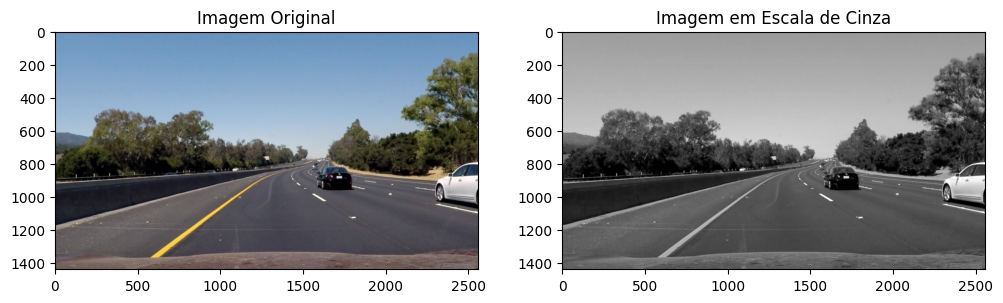

In [23]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Carrega e converte a imagem
img = cv2.imread('lab_images/estrada.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Converte para escala de cinza
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Exibe a imagem original
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Imagem Original')
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Imagem em Escala de Cinza')
plt.show()

## 2. Detecção de Bordas com Algoritmo de Canny

O algoritmo de Canny detecta bordas na imagem, que são essenciais para encontrar as linhas da pista.

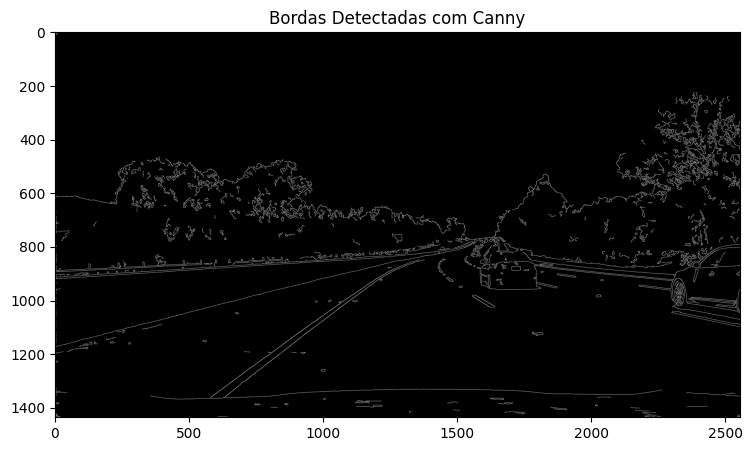

In [24]:
# Aplica o detector de bordas Canny
# Parâmetros: imagem, threshold_baixo, threshold_alto
edges = cv2.Canny(img_gray, 50, 150)

plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap='gray')
plt.title('Bordas Detectadas com Canny')
plt.show()

## 3. Aplicação da Região de Interesse

Focamos apenas na área da estrada onde esperamos encontrar as linhas da pista.

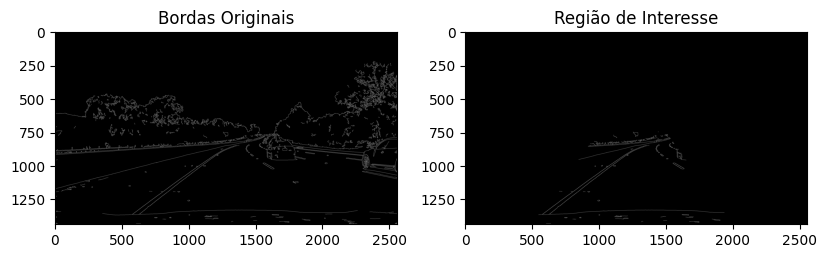

In [29]:
# Função para isolar a região de interesse
def region_of_interest(img):
    """
    Aplica uma máscara para focar apenas na região onde as linhas da pista
    normalmente aparecem (parte inferior da imagem em formato trapezoidal)
    """
    mask = np.zeros_like(img)
    height, width = img.shape[:2]
    
    # Define um polígono trapezoidal na parte inferior da imagem
    polygon = np.array([
        [(500, height), (2000, height), (1500, 750), (1000, 750)]
    ], dtype=np.int32)
    
    cv2.fillPoly(mask, polygon, (255, 255, 255))
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

# Aplica a região de interesse
roi_edges = region_of_interest(edges)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title('Bordas Originais')
plt.subplot(1, 3, 2)
plt.imshow(roi_edges, cmap='gray')
plt.title('Região de Interesse')
plt.show()

## 4. Detecção de Linhas com Transformada de Hough

A Transformada de Hough Probabilística detecta linhas retas na imagem.

Linhas detectadas: 75


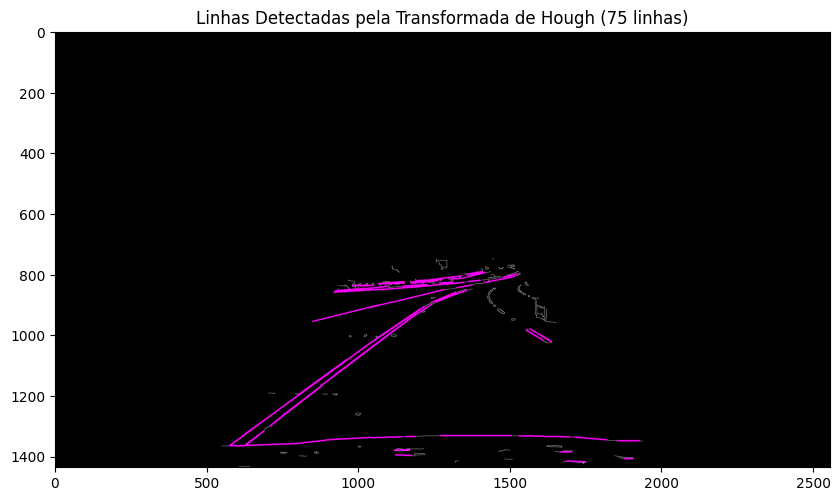

In [30]:
# Aplica a Transformada de Hough para detectar linhas
lines = cv2.HoughLinesP(
    roi_edges,           # Imagem com bordas
    1,                   # Resolução de distância em pixels
    np.pi/180,          # Resolução angular em radianos
    50,                 # Threshold mínimo de votos
    minLineLength=30,   # Comprimento mínimo da linha
    maxLineGap=10       # Gap máximo entre segmentos de linha
)

# Cria uma cópia da imagem para desenhar as linhas
hough_img_rgb = cv2.cvtColor(roi_edges, cv2.COLOR_GRAY2BGR)

print(f"Linhas detectadas: {len(lines)}")

# Desenha todas as linhas detectadas
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_img_rgb, (x1, y1), (x2, y2), (255, 0, 255), 3)

plt.figure(figsize=(10, 8))
plt.imshow(hough_img_rgb)
plt.title(f'Linhas Detectadas pela Transformada de Hough ({len(lines)} linhas)')
plt.show()

## 5. Transformação de Perspectiva (Bird's Eye View)

Convertemos a perspectiva da câmera para uma vista aérea, facilitando a análise das linhas.

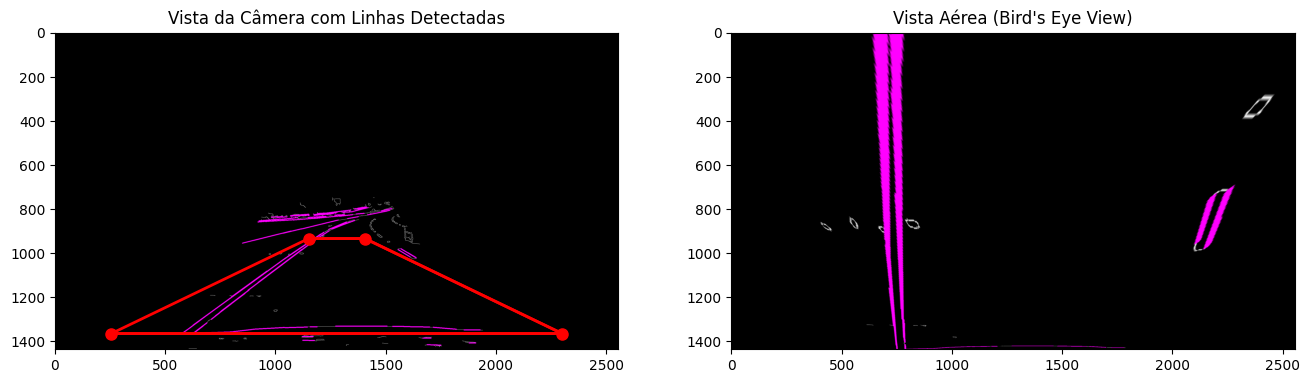

In [31]:
# Altura e largura da imagem
h, w = img.shape[:2]

# Pontos de origem na perspectiva da câmera (ajuste conforme necessário)
src = np.float32([
    [w * 0.45, h * 0.65],  # topo esquerdo
    [w * 0.55, h * 0.65],  # topo direito
    [w * 0.9, h * 0.95],   # base direita
    [w * 0.1, h * 0.95]    # base esquerda
])

# Pontos de destino para formar um retângulo (vista aérea)
dst = np.float32([
    [w * 0.2, 0],      # topo esquerdo
    [w * 0.8, 0],      # topo direito
    [w * 0.8, h],      # base direita
    [w * 0.2, h]       # base esquerda
])

# Calcula a matriz de transformação de perspectiva
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(hough_img_rgb, M, (w, h))

# Exibe os resultados
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(hough_img_rgb)
plt.title('Vista da Câmera com Linhas Detectadas')
plt.plot(*zip(*src), marker='o', color='red', markersize=8, linewidth=2)
plt.plot([src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]], 
         [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]], 'r-', linewidth=2)

plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title('Vista Aérea (Bird\'s Eye View)')
plt.show()

## 6. Análise das Linhas: Reta vs Curva

Agora vamos analisar as linhas detectadas para determinar se representam uma estrada reta ou com curvas.

In [32]:
def analyze_lines(lines, img_shape):
    """
    Analisa as linhas detectadas para determinar se formam uma trajetória reta ou curva
    """
    if lines is None or len(lines) == 0:
        return "Nenhuma linha detectada", 0, []
    
    # Separa linhas por lado (esquerda e direita) baseado na posição x
    left_lines = []
    right_lines = []
    center_x = img_shape[1] // 2
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calcula a inclinação da linha
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
            
            # Classifica como linha esquerda ou direita baseado na posição e inclinação
            if x1 < center_x and slope < 0:  # Linha esquerda (inclinação negativa)
                left_lines.append((slope, x1, y1, x2, y2))
            elif x1 > center_x and slope > 0:  # Linha direita (inclinação positiva)
                right_lines.append((slope, x1, y1, x2, y2))
    
    # Calcula a variação das inclinações
    all_slopes = []
    if left_lines:
        all_slopes.extend([line[0] for line in left_lines])
    if right_lines:
        all_slopes.extend([line[0] for line in right_lines])
    
    if not all_slopes:
        return "Linhas insuficientes para análise", 0, []
    
    # Calcula a variação das inclinações
    slope_variation = np.std(all_slopes)
    avg_slope = np.mean(np.abs(all_slopes))
    
    # Determina se é reta ou curva baseado na variação
    if slope_variation < 0.3 and avg_slope < 0.5:
        road_type = "ESTRADA RETA"
    elif slope_variation < 0.5:
        road_type = "CURVA SUAVE"
    else:
        road_type = "CURVA ACENTUADA"
    
    return road_type, slope_variation, all_slopes

# Analisa as linhas detectadas
road_analysis, variation, slopes = analyze_lines(lines, img.shape)

print("="*50)
print("ANÁLISE DA TRAJETÓRIA DA ESTRADA")
print("="*50)
print(f"Tipo de estrada: {road_analysis}")
print(f"Variação das inclinações: {variation:.3f}")
print(f"Número total de linhas: {len(lines)}")
print(f"Inclinações médias: {np.mean(np.abs(slopes)):.3f}")
print("="*50)

# Classificação adicional
if variation < 0.2:
    print("✅ Estrada muito reta - Ideal para velocidade alta")
elif variation < 0.4:
    print("⚠️  Estrada com curvas leves - Velocidade moderada recomendada")
else:
    print("🚨 Estrada com curvas acentuadas - Reduzir velocidade")

ANÁLISE DA TRAJETÓRIA DA ESTRADA
Tipo de estrada: CURVA SUAVE
Variação das inclinações: 0.365
Número total de linhas: 75
Inclinações médias: 0.325
⚠️  Estrada com curvas leves - Velocidade moderada recomendada


## 7. Visualização Final Comparativa

Comparação entre a detecção original e a vista aérea para melhor compreensão.

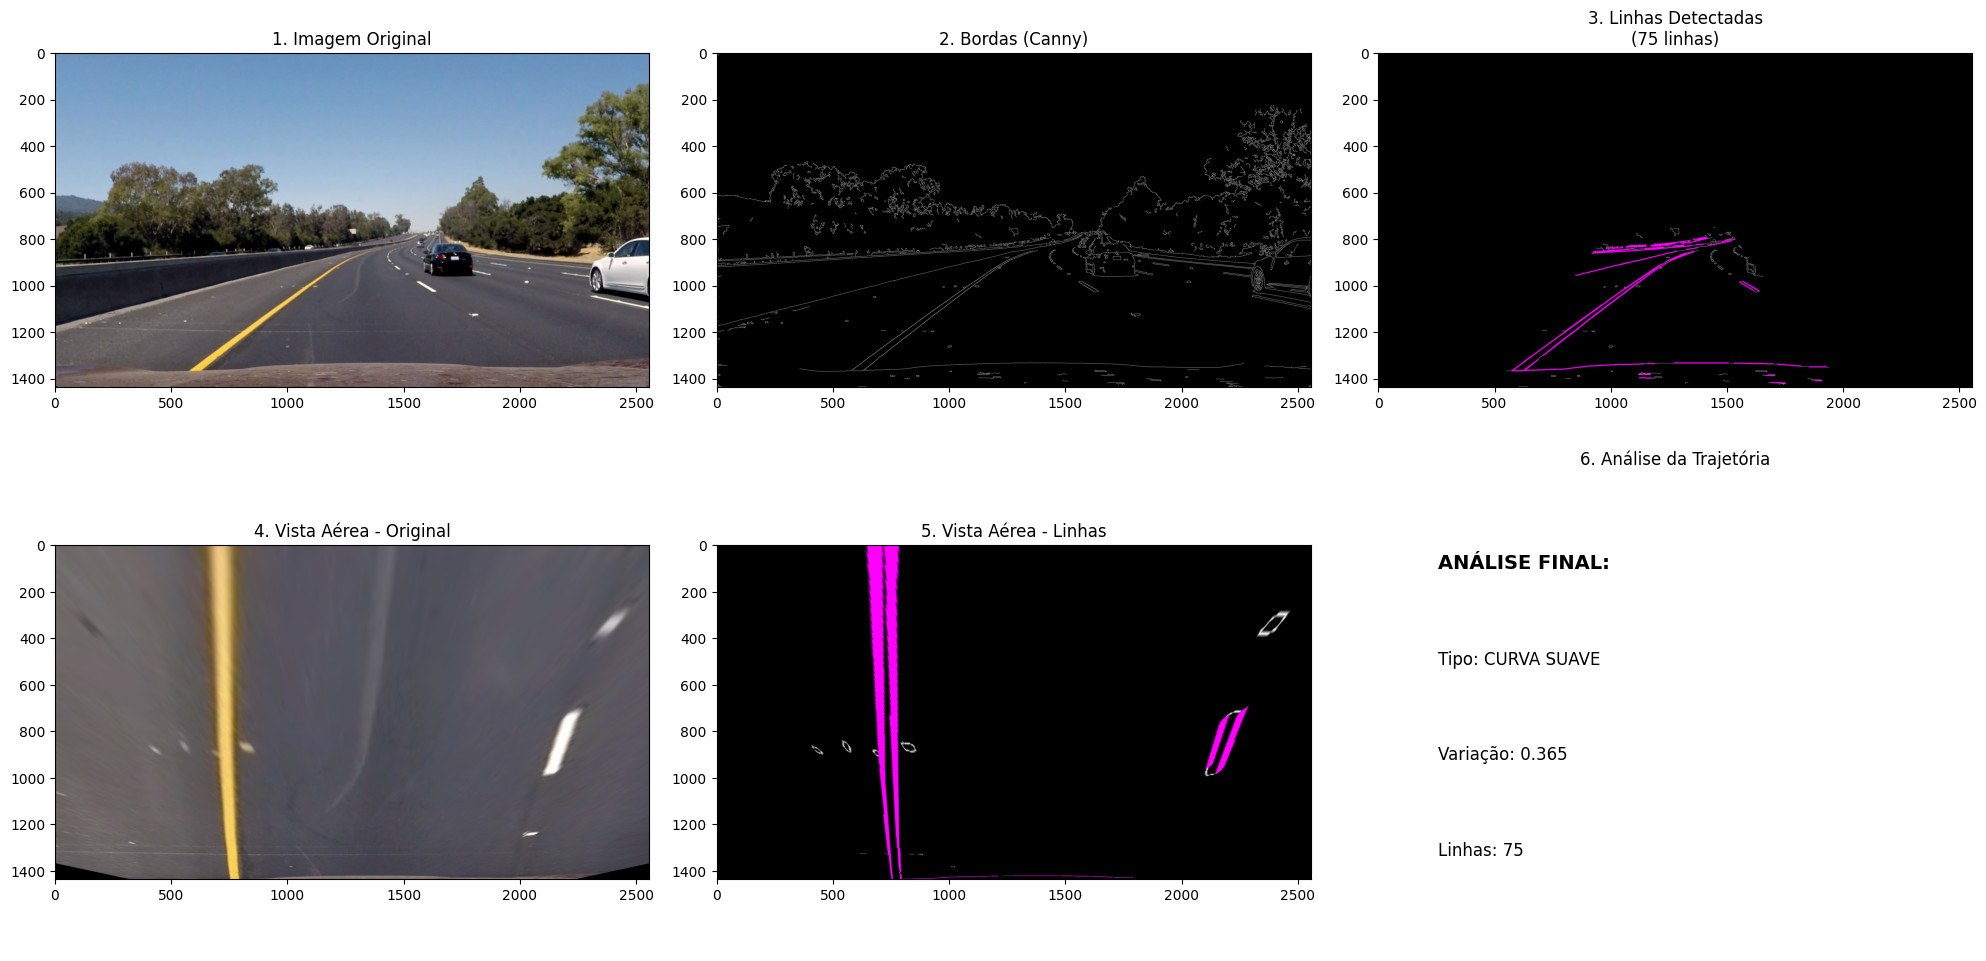

In [34]:
# Aplica a transformação na imagem original para comparação
warped_original = cv2.warpPerspective(img, M, (w, h))

plt.figure(figsize=(20, 10))

# Imagem original
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('1. Imagem Original')

# Bordas detectadas
plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('2. Bordas (Canny)')

# Linhas detectadas na vista da câmera
plt.subplot(2, 3, 3)
plt.imshow(hough_img_rgb)
plt.title(f'3. Linhas Detectadas\n({len(lines)} linhas)')

# Imagem original em vista aérea
plt.subplot(2, 3, 4)
plt.imshow(warped_original)
plt.title('4. Vista Aérea - Original')

# Linhas em vista aérea
plt.subplot(2, 3, 5)
plt.imshow(warped)
plt.title('5. Vista Aérea - Linhas')

# Análise final
plt.subplot(2, 3, 6)
plt.text(0.1, 0.8, f'ANÁLISE FINAL:', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f'Tipo: {road_analysis}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.4, f'Variação: {variation:.3f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.2, f'Linhas: {len(lines)}', fontsize=12, transform=plt.gca().transAxes)
plt.axis('off')
plt.title('6. Análise da Trajetória')

plt.tight_layout()
plt.show()
